# Analyze SPI1 Mutation Impact Scores
- intersect the region bQTLs with SPI1 seqlets from refined model interpretation (481 for SPI1)
- 

In [2]:
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

def center_window_sum(a, snp, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(a[snp][start:end])
    return score

def calc_bis_score(a, win):
    #return max_sub_array_sum(a, size)
    win_sums = []
    for snp in range(len(a)):
        win_sum = center_window_sum(a, snp, win)
        win_sums.append(win_sum)
    return win_sums

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = calc_bis_score(snp_diffs[i], 11)
    # elementwise max among 3 lists
    max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    lines     = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            lines.append(line)
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals, lines

('snp_orig shape=', (1000, 4), 481)
('snp_diff 1 shape=', (1000, 4))
('snp_diff 2 shape=', (1000, 4))
('snp_diff 3 shape=', (1000, 4))


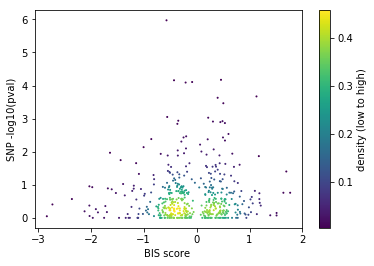

<Figure size 432x288 with 0 Axes>

In [3]:
#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
bis_scores = get_bis_scores(snp_diffs)



#snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
snp_dir  = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
#snp_file = "SPI1_10k.txt"
snp_file = "SPI1_under_seqlet.txt"

snp_pvals, lines = get_snp_pvals(snp_dir + snp_file)

#print(len(snp_pvals))
#print(len(bis_scores))

#%matplotlib inline
tf = 'SPI1'

%matplotlib inline
import matplotlib as mpl
#mpl.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)

x=bis_scores[:]
y=snp_pvals[:]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("BIS score ")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
plt.savefig("deeplift_score_vs_pval.png")    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

-----
scores/interpret.fa0
(481, 1000, 4)
[[-0.00560086 -0.06717713 -0.03118636  0.15850304]
 [-0.13393517  0.07199512  0.14960827 -0.21038026]
 [-0.05767633 -0.0253137   0.0784438   0.08501775]
 [ 0.03590634 -0.04272914  0.06870566  0.0083276 ]
 [-0.03097517  0.10545551  0.03441507  0.00827684]
 [-0.02685852  0.1224499  -0.00769844 -0.05106487]
 [ 0.0022236   0.02578901  0.03706117  0.0158956 ]
 [ 0.04174491 -0.03489379  0.06263702 -0.13991933]
 [ 0.08577125 -0.08862283  0.03989351 -0.05871441]
 [ 0.0000509  -0.15114574 -0.02751781  0.0425244 ]]
-----
0 chr10:82295805 G->A score=-0.56927 loss
1 chr16:89234011 C->A score=0.46045 loss
('CCTTCCCCCA[C]CCGCCTCCA', 'importance score for original sequence')


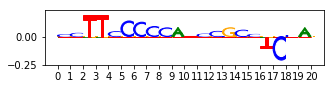

('CCTTCCCCCA[A]CCGCCTCCA', 'importance score for mutated sequence ')


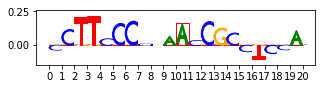

Mutation Impact Score 


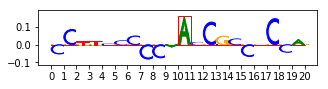

2 chr12:92802124 T->G score=-0.42726 gain
3 chr7:5125265 G->T score=-0.08484 loss
('GCAGCACTCA[G]AACTGCATC', 'importance score for original sequence')


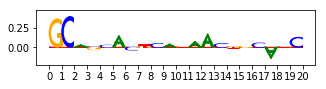

('GCAGCACTCA[T]AACTGCATC', 'importance score for mutated sequence ')


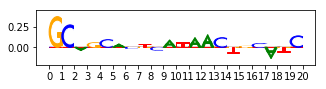

Mutation Impact Score 


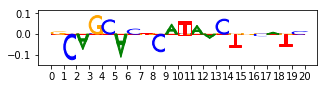

4 chr19:1194698 G->T score=-0.20815 loss
('AGCGGTCCGC[G]CAGACCGCC', 'importance score for original sequence')


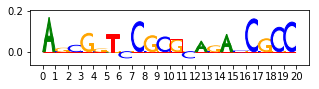

('AGCGGTCCGC[T]CAGACCGCC', 'importance score for mutated sequence ')


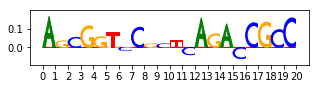

Mutation Impact Score 


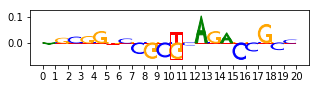

5 chr2:233470999 G->A score=1.13110 loss
6 chr6:15691669 A->C score=0.39709 loss
('TCCGGTCCTG[A]GGCTGCAGA', 'importance score for original sequence')


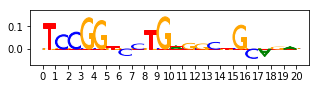

('TCCGGTCCTG[C]GGCTGCAGA', 'importance score for mutated sequence ')


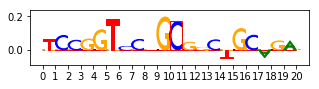

Mutation Impact Score 


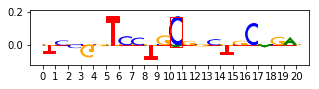

7 chr3:140911331 A->G score=0.50480 gain
8 chr12:45342735 A->G score=-0.55567 loss
9 chr8:141467847 G->A score=0.21897 loss
('TCCTACTGGC[G]GCCGAGCCG', 'importance score for original sequence')


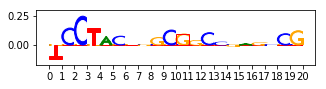

('TCCTACTGGC[A]GCCGAGCCG', 'importance score for mutated sequence ')


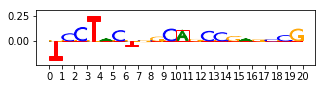

Mutation Impact Score 


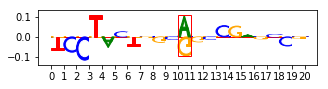

10 chr10:129948449 C->T score=-0.34669 loss
('ATCAGGGCCC[C]CGCGCCCTT', 'importance score for original sequence')


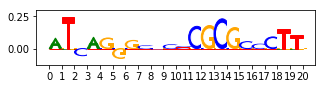

('ATCAGGGCCC[T]CGCGCCCTT', 'importance score for mutated sequence ')


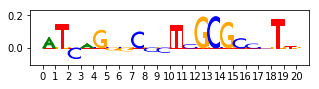

Mutation Impact Score 


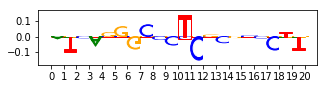

11 chr15:22462181 C->T score=0.48907 loss
('CCTTTGTGGT[C]CTGAGCGCC', 'importance score for original sequence')


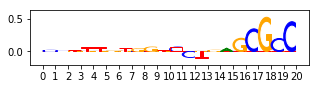

('CCTTTGTGGT[T]CTGAGCGCC', 'importance score for mutated sequence ')


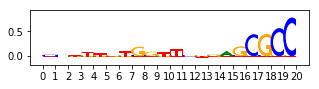

Mutation Impact Score 


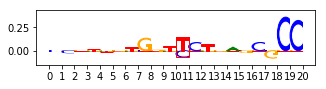

12 chr10:70997596 A->G score=0.30823 loss
('tctatccttc[a]ctcgcggtg', 'importance score for original sequence')


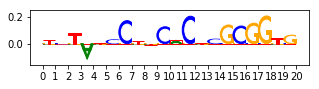

('TCTATCCTTC[G]CTCGCGGTG', 'importance score for mutated sequence ')


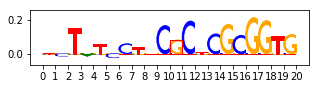

Mutation Impact Score 


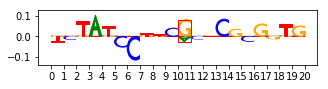

13 chr5:80491022 C->T score=0.44839 loss
('GGGCCCGCGC[C]AGAGCCAAT', 'importance score for original sequence')


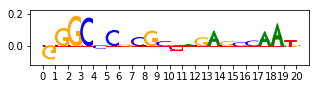

('GGGCCCGCGC[T]AGAGCCAAT', 'importance score for mutated sequence ')


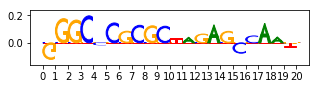

Mutation Impact Score 


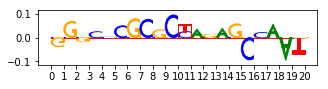

14 chr17:55038490 C->A score=0.53431 loss
15 chr3:125485254 A->C score=-0.36369 loss
('GTCCGCGGTG[A]GCGCGGGCG', 'importance score for original sequence')


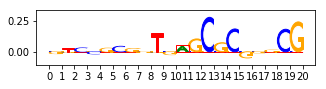

('GTCCGCGGTG[C]GCGCGGGCG', 'importance score for mutated sequence ')


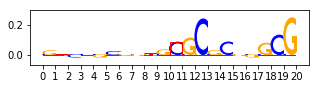

Mutation Impact Score 


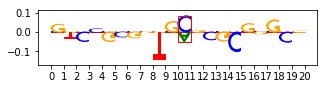

16 chr6:114180276 G->A score=0.60180 gain
17 chr6:29815984 G->T score=-0.19739 loss
('GAAAGGAAGA[G]TGCAGACCG', 'importance score for original sequence')


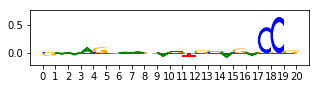

('GAAAGGAAGA[T]TGCAGACCG', 'importance score for mutated sequence ')


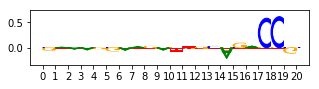

Mutation Impact Score 


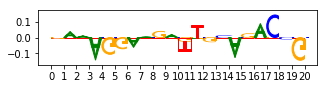

18 chr14:106873719 T->C score=-0.24732 gain
19 chr14:106873719 T->C score=0.49783 gain
20 chr12:52419629 G->T score=-0.85670 loss
21 chr17:39819060 G->T score=0.20878 loss
('TCACCTGGCG[G]AGCAGCAGC', 'importance score for original sequence')


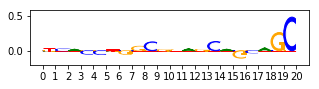

('TCACCTGGCG[T]AGCAGCAGC', 'importance score for mutated sequence ')


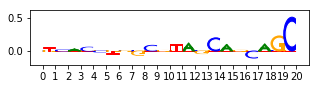

Mutation Impact Score 


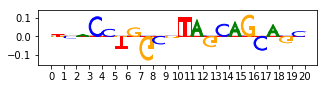

22 chr3:16552221 G->C score=0.53551 loss
23 chr19:36618896 A->T score=-0.28857 loss
('ATTTCCCAGA[A]AACTACGCG', 'importance score for original sequence')


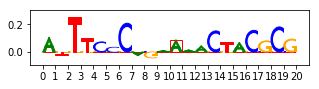

('ATTTCCCAGA[T]AACTACGCG', 'importance score for mutated sequence ')


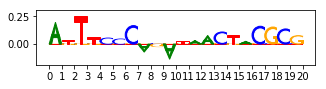

Mutation Impact Score 


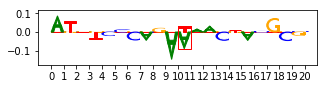

24 chr2:85934499 C->A score=0.06538 gain
25 chr10:129948436 C->A score=-1.00228 loss
26 chr10:97453952 G->A score=-0.20097 loss
('GGCGGTAGGA[G]TTCGGCGGA', 'importance score for original sequence')


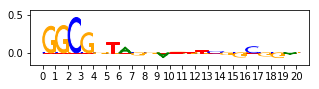

('GGCGGTAGGA[A]TTCGGCGGA', 'importance score for mutated sequence ')


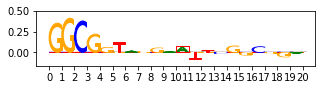

Mutation Impact Score 


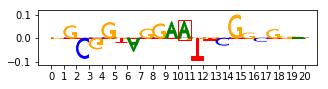

27 chr5:156349362 T->C score=0.32196 loss
('CAAAAATCTC[T]GAAAACCCA', 'importance score for original sequence')


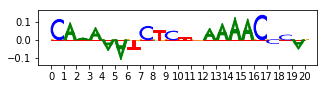

('CAAAAATCTC[C]GAAAACCCA', 'importance score for mutated sequence ')


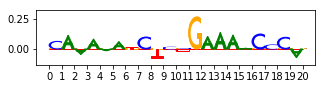

Mutation Impact Score 


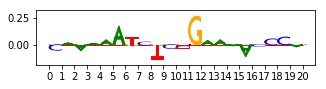

28 chr3:53231295 C->T score=-0.35728 loss
('tccccgcccc[c]cccaacttc', 'importance score for original sequence')


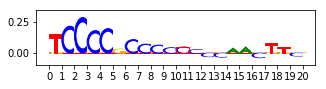

('TCCCCGCCCC[T]CCCAACTTC', 'importance score for mutated sequence ')


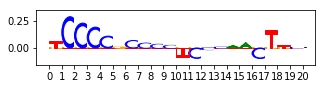

Mutation Impact Score 


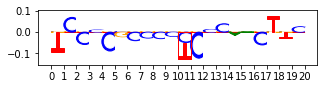

29 chr7:92533838 T->C score=0.09048 loss
('tgcagccaca[t]ggccccaca', 'importance score for original sequence')


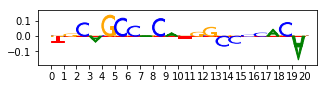

('TGCAGCCACA[C]GGCCCCACA', 'importance score for mutated sequence ')


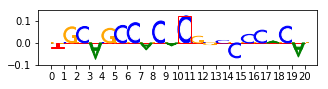

Mutation Impact Score 


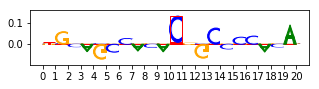

30 chr13:51486350 C->T score=-1.63691 loss
31 chr13:48612226 T->C score=-0.23799 loss
('GGCGCTGTGC[T]GGGTCAGGC', 'importance score for original sequence')


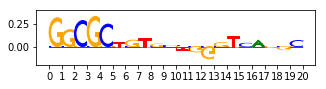

('GGCGCTGTGC[C]GGGTCAGGC', 'importance score for mutated sequence ')


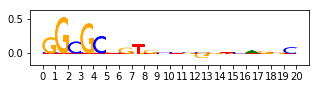

Mutation Impact Score 


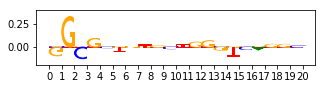

32 chr7:44059948 A->T score=0.67420 loss
33 chr7:139762781 A->G score=-0.67847 loss
34 chr5:56795441 A->T score=0.18722 loss
('CATTCTTTAG[A]GCCTAACTG', 'importance score for original sequence')


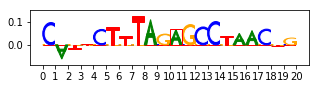

('CATTCTTTAG[T]GCCTAACTG', 'importance score for mutated sequence ')


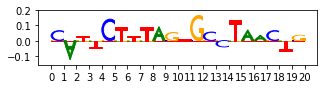

Mutation Impact Score 


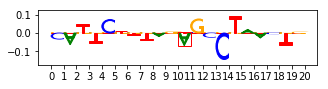

35 chr10:76995904 T->G score=0.43160 loss
('ACTGCGCCCC[T]GCGGGGAGC', 'importance score for original sequence')


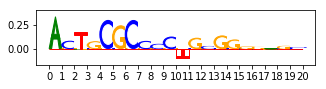

('ACTGCGCCCC[G]GCGGGGAGC', 'importance score for mutated sequence ')


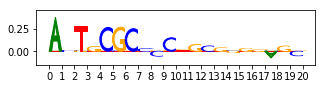

Mutation Impact Score 


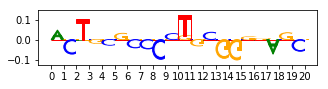

36 chr17:43212777 C->A score=-0.54662 loss
37 chr19:51286985 G->A score=-0.35518 loss
('ACCAATTTCT[G]GCTGAGAAA', 'importance score for original sequence')


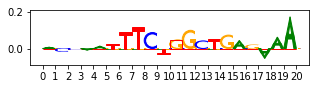

('ACCAATTTCT[A]GCTGAGAAA', 'importance score for mutated sequence ')


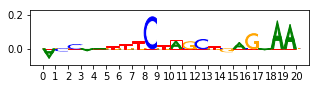

Mutation Impact Score 


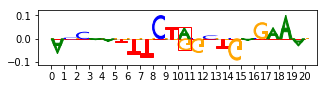

38 chr11:62607068 A->G score=1.17548 loss
39 chr14:106765395 T->C score=-1.43611 gain
40 chr7:97650991 A->T score=-1.14318 loss
41 chr10:97989464 G->A score=-0.13575 loss
('ACGCGCGTGC[G]CAGCCAGCA', 'importance score for original sequence')


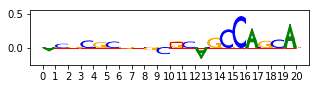

('ACGCGCGTGC[A]CAGCCAGCA', 'importance score for mutated sequence ')


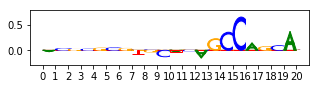

Mutation Impact Score 


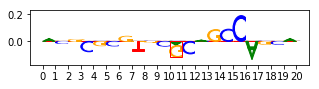

42 chr10:88727079 A->C score=0.43541 loss
('TAGGGGAGAC[A]CCAGCAGAG', 'importance score for original sequence')


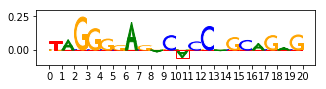

('TAGGGGAGAC[C]CCAGCAGAG', 'importance score for mutated sequence ')


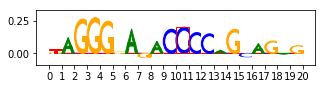

Mutation Impact Score 


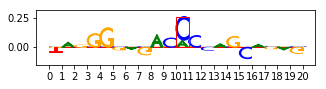

43 chr5:132165762 G->C score=0.54264 loss
44 chr19:39931059 G->C score=0.81204 gain
45 chr17:80452726 C->T score=-0.53317 loss
46 chr9:131419025 C->A score=0.35823 loss
('TCCGCCCTCT[C]GTGCGGACG', 'importance score for original sequence')


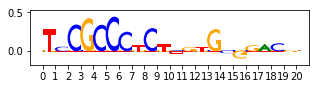

('TCCGCCCTCT[A]GTGCGGACG', 'importance score for mutated sequence ')


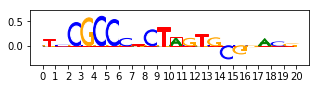

Mutation Impact Score 


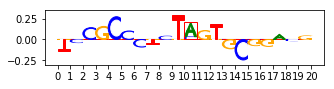

47 chr5:139536922 A->G score=0.17705 gain
48 chr18:10560456 C->T score=-0.20027 loss
('TTCTCCAGAG[C]GCTTCCCTG', 'importance score for original sequence')


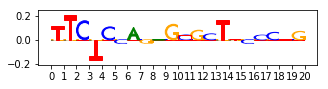

('TTCTCCAGAG[T]GCTTCCCTG', 'importance score for mutated sequence ')


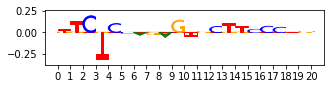

Mutation Impact Score 


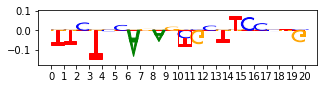

49 chr19:4400762 C->A score=0.36693 loss
('TGGAGGTGAC[C]CTAACGTCT', 'importance score for original sequence')


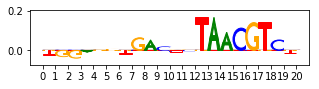

('TGGAGGTGAC[A]CTAACGTCT', 'importance score for mutated sequence ')


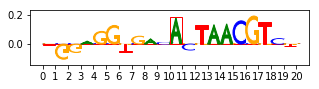

Mutation Impact Score 


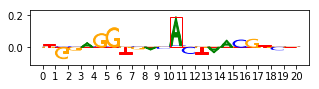

50 chr3:58173624 A->C score=0.30091 gain
51 chr2:85154290 C->T score=0.70538 loss
52 chr22:25758307 G->A score=-0.48309 loss
('GGGCGCCCAG[G]TGATGGTGA', 'importance score for original sequence')


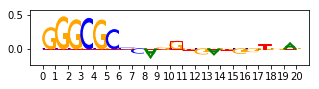

('GGGCGCCCAG[A]TGATGGTGA', 'importance score for mutated sequence ')


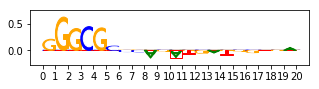

Mutation Impact Score 


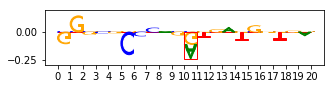

53 chr11:59521627 T->C score=0.19547 loss
('GAAGCCCTCC[T]GGTACTAAG', 'importance score for original sequence')


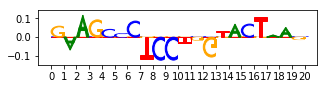

('GAAGCCCTCC[C]GGTACTAAG', 'importance score for mutated sequence ')


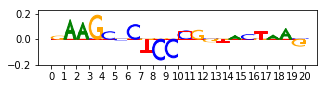

Mutation Impact Score 


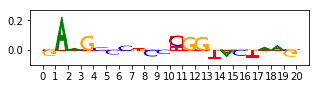

54 chr2:113357766 G->T score=0.39790 loss
('TAAGATGCTG[G]CTCTGCCGC', 'importance score for original sequence')


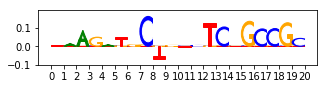

('TAAGATGCTG[T]CTCTGCCGC', 'importance score for mutated sequence ')


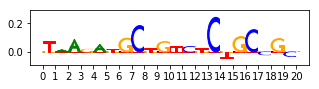

Mutation Impact Score 


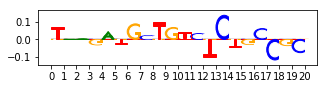

55 chr17:66007419 C->G score=-0.54318 gain
56 chr6:27763793 T->C score=0.34984 loss
('AAGTATGAAA[T]AATGggttt', 'importance score for original sequence')


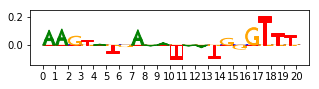

('AAGTATGAAA[C]AATGGGTTT', 'importance score for mutated sequence ')


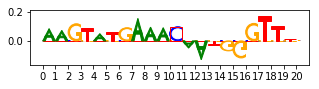

Mutation Impact Score 


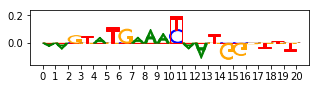

57 chr9:92213249 C->A score=1.69476 loss
58 chr18:45275638 A->C score=-0.18002 loss
('CGCGGCCCTG[A]GCTCTGCTG', 'importance score for original sequence')


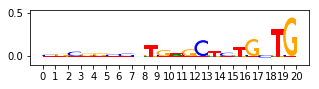

('CGCGGCCCTG[C]GCTCTGCTG', 'importance score for mutated sequence ')


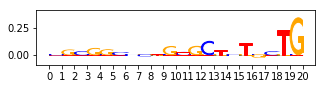

Mutation Impact Score 


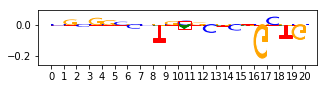

59 chr22:42062822 C->T score=-0.51484 loss
60 chr4:38063842 G->A score=-0.36304 loss
('GTTGCTCCCC[G]CATCTTGAT', 'importance score for original sequence')


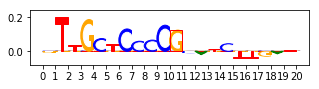

('GTTGCTCCCC[A]CATCTTGAT', 'importance score for mutated sequence ')


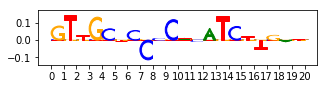

Mutation Impact Score 


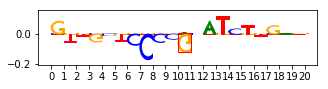

61 chr8:11627261 C->G score=-0.50370 loss
62 chr16:86050211 A->G score=0.23280 loss
('AAATTACACG[A]TGTTCCTTC', 'importance score for original sequence')


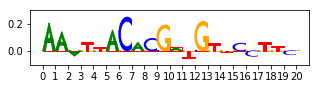

('AAATTACACG[G]TGTTCCTTC', 'importance score for mutated sequence ')


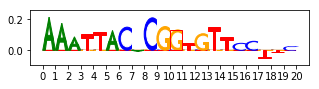

Mutation Impact Score 


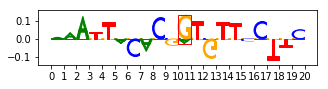

63 chr6:29816010 C->A score=0.26735 loss
('GGCGCCGCTG[C]ACTGCTTCT', 'importance score for original sequence')


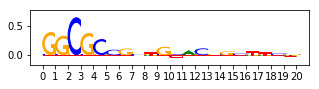

('GGCGCCGCTG[A]ACTGCTTCT', 'importance score for mutated sequence ')


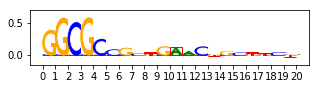

Mutation Impact Score 


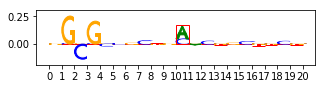

64 chr19:3104156 G->C score=0.44242 gain
65 chr19:6862969 G->A score=-1.09057 loss
66 chr5:41925326 G->A score=-0.32777 loss
('GAACGCCCGA[G]GGCGCCCTC', 'importance score for original sequence')


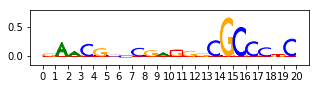

('GAACGCCCGA[A]GGCGCCCTC', 'importance score for mutated sequence ')


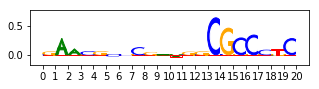

Mutation Impact Score 


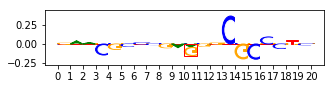

67 chr19:39127748 C->T score=0.52448 loss
68 chr13:38923863 T->C score=-0.45263 gain
69 chr12:98897957 G->A score=-0.81420 loss
70 chr8:82692899 C->T score=-0.23521 loss
('TGCTGCCGCT[C]GTTGTTCCC', 'importance score for original sequence')


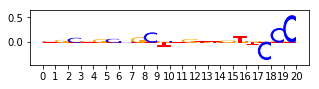

('TGCTGCCGCT[T]GTTGTTCCC', 'importance score for mutated sequence ')


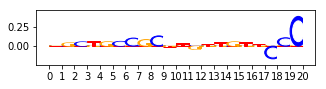

Mutation Impact Score 


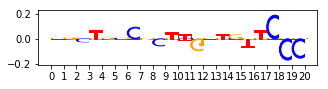

71 chr11:63920689 A->G score=0.64992 gain
72 chr14:107119927 C->T score=-0.32723 gain
73 chr10:73808483 C->T score=0.27852 loss
('TGCATAGGTC[C]GTGCTGTCT', 'importance score for original sequence')


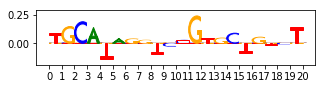

('TGCATAGGTC[T]GTGCTGTCT', 'importance score for mutated sequence ')


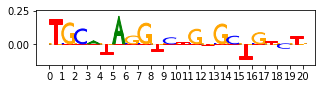

Mutation Impact Score 


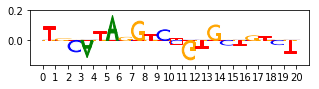

74 chr12:124155693 G->A score=0.08045 loss
('AGATGGCGGC[G]GCGGGGCAG', 'importance score for original sequence')


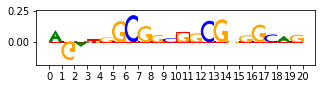

('AGATGGCGGC[A]GCGGGGCAG', 'importance score for mutated sequence ')


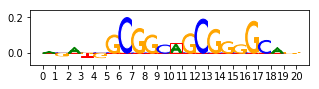

Mutation Impact Score 


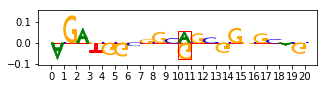

75 chr4:693313 G->A score=-0.42449 loss
('ccctcaccac[g]attgttgcg', 'importance score for original sequence')


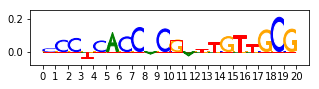

('CCCTCACCAC[A]ATTGTTGCG', 'importance score for mutated sequence ')


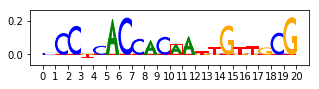

Mutation Impact Score 


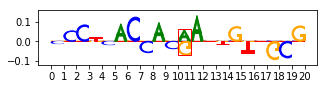

76 chr9:130880035 G->A score=-0.80341 loss
77 chr8:22419588 T->C score=0.49138 loss
('CCGTCTGGGC[T]CTGTCCCAT', 'importance score for original sequence')


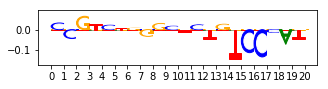

('CCGTCTGGGC[C]CTGTCCCAT', 'importance score for mutated sequence ')


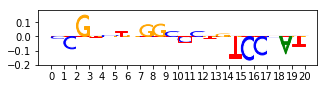

Mutation Impact Score 


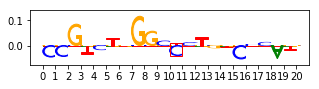

78 chr10:121302900 C->A score=-0.09246 loss
('CCCCAGGGCC[C]GTGCGCTGA', 'importance score for original sequence')


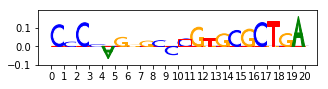

('CCCCAGGGCC[A]GTGCGCTGA', 'importance score for mutated sequence ')


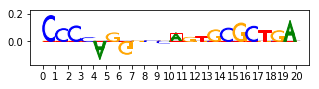

Mutation Impact Score 


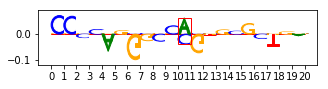

79 chr19:23869684 G->A score=0.33272 gain
80 chr19:12943638 G->C score=-0.40481 gain
81 chr14:107238993 C->T score=-0.44508 loss
('GTCCTGAGCG[C]CACCTCATG', 'importance score for original sequence')


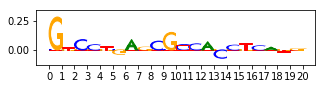

('GTCCTGAGCG[T]CACCTCATG', 'importance score for mutated sequence ')


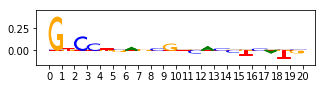

Mutation Impact Score 


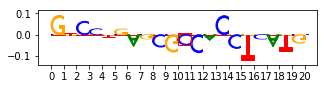

82 chr10:104594906 T->G score=0.43902 loss
('AAGAAAAGGC[T]GCATTGCGC', 'importance score for original sequence')


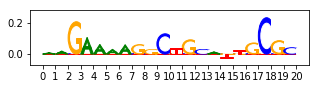

('AAGAAAAGGC[G]GCATTGCGC', 'importance score for mutated sequence ')


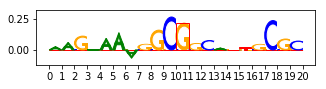

Mutation Impact Score 


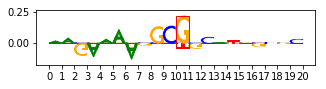

83 chr21:35720370 A->G score=0.71277 loss
84 chr6:29816034 C->A score=0.45811 loss
('CCAGGAGGTG[C]CTGCTGGGG', 'importance score for original sequence')


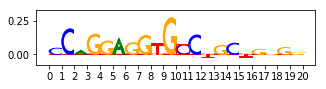

('CCAGGAGGTG[A]CTGCTGGGG', 'importance score for mutated sequence ')


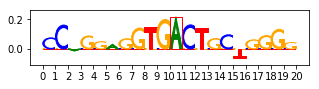

Mutation Impact Score 


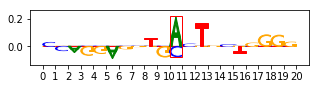

85 chr22:46959430 T->C score=0.24852 gain
86 chr5:56795458 C->A score=-0.03310 loss
('CTGGTAAAAA[C]AAACAAACA', 'importance score for original sequence')


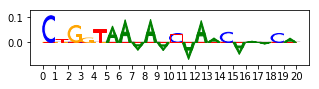

('CTGGTAAAAA[A]AAACAAACA', 'importance score for mutated sequence ')


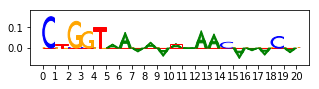

Mutation Impact Score 


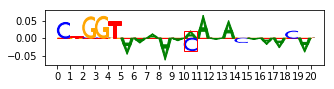

87 chr18:865028 C->A score=-0.55910 gain
88 chr6:41499968 A->T score=0.77817 loss
89 chr9:71199545 T->C score=-0.39542 gain
90 chr6:16762849 G->A score=0.13482 loss
('ACCTCCACGC[G]AAGGAATCT', 'importance score for original sequence')


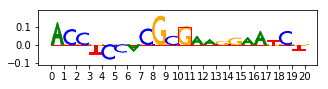

('ACCTCCACGC[A]AAGGAATCT', 'importance score for mutated sequence ')


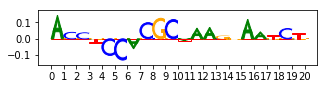

Mutation Impact Score 


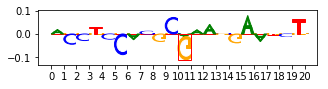

91 chr4:27686352 G->T score=-0.35642 loss
('AGAGAGTCGG[G]AGGTTTCGC', 'importance score for original sequence')


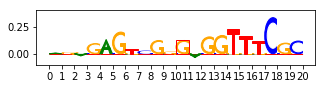

('AGAGAGTCGG[T]AGGTTTCGC', 'importance score for mutated sequence ')


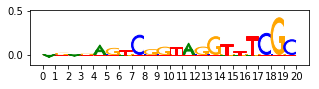

Mutation Impact Score 


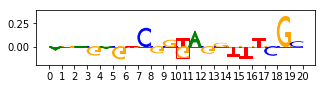

92 chr6:97345778 C->G score=-1.38925 loss
93 chr11:113160503 G->A score=-0.80730 loss
94 chr17:40540975 A->G score=-0.33098 loss
('CCACGCGGGA[A]TCAGCTAGT', 'importance score for original sequence')


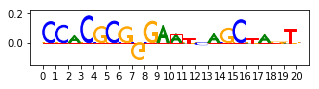

('CCACGCGGGA[G]TCAGCTAGT', 'importance score for mutated sequence ')


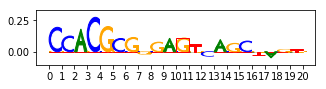

Mutation Impact Score 


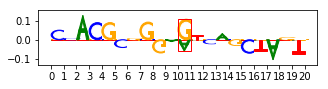

95 chr20:4588047 T->C score=0.27269 gain
96 chr19:6862938 C->G score=-0.36480 loss
('TAAAGCCGCG[C]TTGCCCCCT', 'importance score for original sequence')


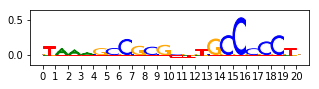

('TAAAGCCGCG[G]TTGCCCCCT', 'importance score for mutated sequence ')


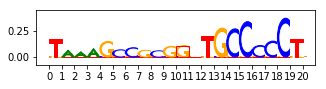

Mutation Impact Score 


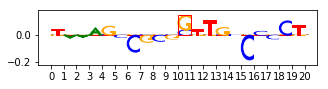

97 chr15:31727654 G->A score=-1.18701 loss
98 chr16:86050201 A->G score=-0.51575 loss
99 chr7:105650100 G->A score=-0.24856 loss
('TGGAGGAGGC[G]GGCGCCCCC', 'importance score for original sequence')


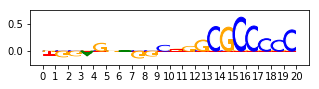

('TGGAGGAGGC[A]GGCGCCCCC', 'importance score for mutated sequence ')


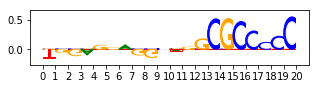

Mutation Impact Score 


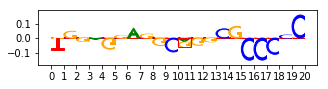

('max_mis_score=\n', [-0.5692663, 0.4604537, -0.42726058, -0.08484041, -0.2081535])


In [5]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
seqs        = {}
snp_orig, orig_seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [0,2,0] # A->G(1), C->A(0), C->T(2)

snp_desc   = ["SNP chr4:176935913 C->A", "SNP chr12:16789835 C->T", "SNP chr12:8608502 T->A"]

def seqs_str(seqs, snp):
    return seqs[snp][490:500] + '[' + seqs[snp][500:501] + ']' + seqs[snp][501:510]

thresh = 0.5

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))

for i in range(3): # each i is an allele
    snp_alleles[i], seqs[i]  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

for snp in range(100):

    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    line = lines[snp]
    fields = line.split('\t')
    alt_depth = int(fields[3])
    ref_depth = int(fields[4])
    print("%d %s:%s %s->%s score=%.5f %s" % (snp, fields[0], fields[1], fields[6], fields[5], x[snp], 
          "gain" if alt_depth > ref_depth else "loss"))

    if not (abs(x[snp]) > thresh or alt_depth > ref_depth):
        print(seqs_str(orig_seqs, snp), "importance score for original sequence")
        viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}

    for i in range(3): # each i is an allele
        snp_allele = snp_alleles[i]
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if abs(x[snp]) > thresh or alt_depth > ref_depth:
            continue
        if fields[5] == seqs[i][snp][500]:
        #if i == allele_idx[snp]:

            print(seqs_str(seqs[i], snp), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
'''
for i in range(3):
    snp_diff = snp_diffs[i]
    print("allele", i)
    print(snp_diff[snp][499:502])

    win = 3
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(snp_diff[snp][start:end])
    print(start, end, score)
    
    win_sums = center_window_sum(snp_diff, snp, 3)
    print("winsums=", win_sums)
    bis_scores[i] = calc_bis_score(snp_diffs[i], 3)
    # elementwise max among 3 lists
    print("bis_scores for allele", i, bis_scores[i])

max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
print("max_bis_score=\n", max_bis_score[:5])
'''

max_bis_score = get_bis_scores(snp_diffs)
print("max_mis_score=\n", max_bis_score[:5])
